import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegKeyRadius import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step002_det_P003_keyRadius_v1' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 20
weight_reg = 2.0
weight_background = 0.1

#model parameters
batch_size = 12
newSize = [512, 512]
total_epoch_num = 500  # total number of epoch in training
base_lr = 0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


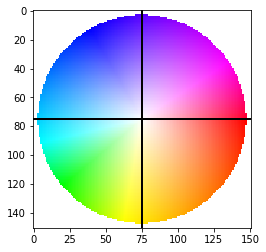

In [3]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
plt.imshow(objDemoShowFlow.FlowColorChart)
#plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)
#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [4]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'
with open('dbinfo.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)    
#dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=newSize, 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

4997 1218


In [5]:
################## init model ###################
initModel = PollenDet_SegKeyRadius(34, scaleList=scaleList, pretrained=True)
initModel.to(device);

using pretrained model


In [6]:
# loss for regression with masking
class MaskWeightedL1(nn.Module):
    def __init__(self, wBG=0.5, wFactor=1):
        super(MaskWeightedL1, self).__init__()        
        self.wBG = wBG
        self.wFactor = wFactor
        
    def forward(self, inputs, target, segMask, overlapMask=0): 
        N, C, H, W = inputs.shape
        output = inputs - target
        totalNum = H * W * N
        output = torch.abs(output)
        output = torch.mean(output, 1, keepdim=True)
                
        output = output * (segMask + self.wBG) * (1-overlapMask)
        
        lossValue = output.sum() / totalNum
        return lossValue*self.wFactor

In [7]:
# loss for (binary) segmentation
weight = torch.ones(2)
weight[0] = 0.5
weight = weight.to(device)
#lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')
lossFunc_seg = nn.BCELoss(reduction='mean')

lossFunc_reg = MaskWeightedL1(wBG=weight_background, wFactor=weight_reg)

In [8]:
optimizer = optim.Adam([{'params': initModel.encoder.parameters()},
                        {'params': initModel.decoder.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

In [9]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_seg, lossFunc_reg,
                       optimizer, exp_lr_scheduler,
                       scaleList=scaleList,
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, 
                       device=device,
                       freqShow=freqShow)


Epoch 1/500
----------
train
	20/417 seg:0.220, reg:0.041
	40/417 seg:0.158, reg:0.029
	60/417 seg:0.130, reg:0.022
	80/417 seg:0.113, reg:0.018
	100/417 seg:0.103, reg:0.016
	120/417 seg:0.094, reg:0.015
	140/417 seg:0.088, reg:0.014
	160/417 seg:0.083, reg:0.013
	180/417 seg:0.080, reg:0.012
	200/417 seg:0.077, reg:0.012
	220/417 seg:0.075, reg:0.011
	240/417 seg:0.073, reg:0.010
	260/417 seg:0.072, reg:0.010
	280/417 seg:0.070, reg:0.010
	300/417 seg:0.069, reg:0.010
	320/417 seg:0.068, reg:0.010




Leaving Blank
-----